Welcome to assignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



Task 1: Feature Generation (15%)
Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
Allocate 10% of the data for validation.

Insert your code here for Task 1





In [1]:
# import the necessary packages

import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

# imports for task 2
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [2]:
# Load the DenseNet model pre-trained on ImageNet
model = densenet121(pretrained=True)
# Modify the model to remove the last fully connected layer
model = torch.nn.Sequential(*list(model.children())[:-1])
# Add a global average pooling layer to the model
model.add_module("global_avg_pool", torch.nn.AdaptiveAvgPool2d(1))
# Set the model to evaluation mode
model.eval()

# Define a series of transformations for preprocessing the images
preprocess = transforms.Compose(
    [
        transforms.Resize(256),  # Resize the input images to 256x256
        transforms.CenterCrop(224),  # Crop the images to 224x224
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize the images
    ]
)

# Specify the directory containing the dataset
dataset_dir = "train"

# Initialize lists to hold image paths and their corresponding labels
image_paths = []
labels = []

# Iterate through each folder in the dataset directory
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Iterate through each file in the folder
        for file_name in os.listdir(folder_path):
            # Check if the file is a TIFF image
            if file_name.endswith(".tif"):
                # Append the image path and label to their respective lists
                image_paths.append(os.path.join(folder_path, file_name))
                labels.append(folder_name)

# Convert categorical labels into numeric labels
unique_labels = sorted(set(labels))
label_to_numeric = {label: idx for idx, label in enumerate(unique_labels)}
labels_numeric = [label_to_numeric[label] for label in labels]

# Combine image paths and numeric labels into tuples for easy processing
combined = list(zip(image_paths, labels_numeric))

# Split the combined dataset into training/validation and testing sets
train_test_combined, val_combined = train_test_split(
    combined, test_size=0.1, random_state=42
)

# Further split the training/validation set into separate training and validation sets
train_combined, test_combined = train_test_split(
    train_test_combined, test_size=0.1, random_state=42
)


def extract_features_and_labels(combined_data):
    """
    Extract features and labels from the given dataset.

    Parameters:
    - combined_data: A list of tuples, each containing the path to an image and its numeric label.

    Returns:
    - A tuple containing two numpy arrays: one for the extracted features and one for the corresponding labels.
    """
    features = []
    labels = []
    for path, label in combined_data:
        # Load the image from the specified path
        image = Image.open(path)
        # Preprocess the image
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)
        # Extract features using the model
        with torch.no_grad():
            output = model(input_batch)
        features.append(output.squeeze().detach().numpy())
        labels.append(label)
    return np.array(features), np.array(labels)


# Extract features and labels for training, testing, and validation sets
train_features, train_labels = extract_features_and_labels(train_combined)
test_features, test_labels = extract_features_and_labels(test_combined)
val_features, val_labels = extract_features_and_labels(val_combined)


# Save the extracted features and labels to disk
np.save("train_features.npy", train_features)
np.save("test_features.npy", test_features)
np.save("val_features.npy", val_features)
np.save("train_labels.npy", train_labels)
np.save("test_labels.npy", test_labels)
np.save("val_labels.npy", val_labels)

print("Features and labels for training, testing, and validation sets have been saved.")

# Note on fixing potential warning with updated model loading approach:
# Uncomment and use the following code to address deprecation warnings related to loading pretrained models:
# from torchvision.models import densenet121, DenseNet121_Weights
# model_weights = DenseNet121_Weights.IMAGENET1K_V1  # Alternatively, use DenseNet121_Weights.DEFAULT for the latest weights
# model = densenet121(weights=model_weights)
# Modify the model similarly as above to prepare for feature extraction
# model.eval()

c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Features and labels for training, testing, and validation sets have been saved.


 Task 2: High Bias Classification Method (5%)
 Choose a classification method and let is have a high bias.
 Train it on the generated features and discuss why it is underfitting.

 Insert your code here for Task 2




In [3]:
# Use a multi-class SVM method to classify data choosing intentionally poor values for C to incentivise overgeneralization 
hb_svm_model = svm.SVC(kernel="linear", C=0.00001)

#Fit the model to the training data and score it on the train and validation data for comparison
hb_svm_model.fit(train_features,train_labels)
hb_svm_train_score = hb_svm_model.score(train_features, train_labels, sample_weight=None)
hb_svm_val_score = hb_svm_model.score(val_features, val_labels, sample_weight=None)

print('Train accuracy:',hb_svm_train_score,'\nValidation Accuracy:',hb_svm_val_score)

Train accuracy: 0.16164817749603805 
Validation Accuracy: 0.10256410256410256


## Discussion

We are able to identify that this model has high bias and low variance through its scoring on the train and validation sets. When a model is underfit we expect to see very low skill on both the training and validation sets. This is due to an overall lack of underfitting by the model to solve the problem and can be caused by various issues with the model. Specifically in this instance, with a very low value for C the model searches for an overly wide boundary that classifies most points into a single class. This method is far too simplistic to solve the problem and as such the model is underfit and has a high bias.

 Task 3: High Variance Classification Method (5%)
 Use the chosen classification method and let it have a high variance.
 Train it on the generated features and discuss why it is overfitting.

 Insert your code here for Task 3




In [4]:
# Use a multi-class SVM method to classify data choosing intentionally poor values for C and gamma to incentivise overfitting 
hb_svm_model = svm.SVC(kernel="rbf", C=1000000, gamma=0.04)

#Fit the model to the training data and score it on the train and validation data for comparison
hb_svm_model.fit(train_features,train_labels)
hb_svm_train_score = hb_svm_model.score(train_features, train_labels, sample_weight=None)
hb_svm_val_score = hb_svm_model.score(val_features, val_labels, sample_weight=None)

print('Train accuracy:',hb_svm_train_score,'\nValidation Accuracy:',hb_svm_val_score)

Train accuracy: 1.0 
Validation Accuracy: 0.5


## Discussion

We are able to identify that this model has high variance and low bias though the scoring on train and validation sets as before. When a model is overfit we expect to see high training skill and low validation skill as we see above. In order to produce a model that overfits setting parameters that incentivise large changes when new datapoints are added is very likely to lead to overfitting. In order to do this we use a very high C and a low gamma to create a thin decision boundary between classes that is fit exactly to the training data such that if a new point outside of the training is added the training process would alter the seperating hyperplane substantially. This results in a hyperplane that is wrapped around the training points and has a very thin margin that does not accept improperly seperated data in the training set and reduces ability to generalize the model.

 Task 4: Balanced Classification Method (15%)
 Use the chosen classification method and let it balance the bias and variance.
 Train it on the generated features, possibly adjusting parameters.
 Discuss insights into achieving balance.

 Insert your code here for Task 4




In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

#In order to indentify the best parameters for our SVM to balance variance and bias we will use a rudementary grid search to identify the optimal hyperparemeters for SVC
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']
C_range = np.logspace(-5, 2, 5)
gamma_range = np.logspace(-5, 2, 5)
param_grid = dict(gamma=gamma_range, C=C_range)

#We preform K-fold cross validation alongside this hyperparameter tuning to ensure we do not overfit the model to one set of validation data
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#As we will be preforming K-fold validation the split of data in part one is not needed due to the splitting in the process of K-fold validation so we recombine the data
not_test_features = np.concatenate((train_features,val_features))
not_test_labels = np.concatenate((train_labels,val_labels))

#Here we preform the grid search by looping through each combination of features and maintaining the features with the highest skill overall measured via accuracy
#Accuracy is chosen as our metric as without any information about what the data classes represent it provides a general and easy to interperit evaluation of skill
best_score = 0
for kernel in kernel_types:
    for c in C_range:
        for g in gamma_range:

            #Here we create and evaluate each model being sure to take the mean preformance of all K-folds to reduce bias introduced if we took the best fold performance
            test_svm_model = svm.SVC(kernel=kernel, C=c, gamma=g) 
            hv_svm_scores = np.mean(cross_val_score(test_svm_model, not_test_features, not_test_labels, cv=10)) # 10 is chosen here as it is industry standard

            #If the combination of hyperparameters produces the strongest model remember its parameters
            if hv_svm_scores > best_score:
                best_score = hv_svm_scores
                best_kernel = kernel
                best_gamma = g
                best_c = c

#Reporting the optimum conditions for SVC on our dataset and saving it to a model for future usage
                
best_svm_model = svm.SVC(kernel=best_kernel, C=best_c, gamma=best_gamma)
print('Best kernel is:',best_kernel)
print('Best gamma is:',best_gamma)
print('Best C is:',best_c)
print('Best score is:',best_score)

Best kernel is: poly
Best gamma is: 0.03162277660168379
Best C is: 0.0005623413251903491
Best score is: 0.9646881287726359


## Discussion

When working to identify the optimum parameters there are a wide range of approaches one could take when trying to tune their model hyperparameters. Since we have a relativly simple model running with short runtime we are able to take advantage of brute force methodologies to tune our hyperparameters properly. If this dataset were instead much larger and our model much more complex we would instead decide between creating a tuning model to learn the best hyperparemeter state for our problem, or manual iteration of parameters sourced from literature for the model type. The second method is reliant on an understanding of the data that we lack for this project as the initial data and preprocessing of the data are both done before our intervention. Overall finding that a polynomial kernal is optimum for our problem tells us that our data is non-linear and as such we should avoid using a comparison of linear methods in the future or implement dimensionality reduction techniques in order to simplify the space. We find that a small value for both gamma and C is optimal showing that if we are able to kernalize the data effectivly the data becomes simply seperable if outliers can be ignored over the boundary.

 Task 5: K-Means Clustering (20%)
 Apply K-Means clustering on the generated features.
 Test with available labels and report accuracy.
 Experiment with automated K and compare with manually set 20 clusters.

 Insert your code here for Task 5




In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import numpy as np
from collections import Counter

# Load features and labels from Numpy files.
train_features = np.load("train_features.npy")
train_labels = np.load("train_labels.npy")
val_features = np.load("val_features.npy")
val_labels = np.load("val_labels.npy")
test_features = np.load("test_features.npy")
test_labels = np.load("test_labels.npy")

# Combine features and labels from training, validation, and test sets for clustering analysis.
features = np.concatenate((train_features, val_features, test_features), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)

#This is calculating the purity of the clustering method
def calculate_custom_accuracy(clusters, true_labels):
    """
    Calculate the custom accuracy for clustering by assigning the most frequent true label
    to each cluster and then comparing these assigned labels to the true labels.

    Parameters:
    - clusters (numpy.ndarray): Cluster assignments for each data point.
    - true_labels (numpy.ndarray): True labels for each data point.

    Returns:
    - float: The accuracy of the clustering based on how well the assigned cluster labels
             match the true labels.
    """
    label_mapping = {}
    for cluster_id in set(clusters):
        # Identify all data points assigned to the current cluster.
        cluster_indices = np.where(clusters == cluster_id)[0]
        # Get the true labels of these data points.
        cluster_labels = true_labels[cluster_indices]
        # Determine the most common label in the cluster.
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        # Assign this label to the cluster.
        label_mapping[cluster_id] = most_common_label
    # Create an array of predicted labels based on the cluster assignments.
    predicted_labels = np.array([label_mapping[cluster_id] for cluster_id in clusters])
    # Calculate and return the accuracy.
    return accuracy_score(true_labels, predicted_labels)


# Initialize variables to track the best number of clusters (k) and the highest accuracy found.
best_k = 2
best_accuracy = 0

# Iterate over a range of k values to find the best one based on custom accuracy.
for k in range(2, 20):
    # Perform KMeans clustering with the current value of k.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(features)
    # Get the cluster assignments for each data point.
    clusters = kmeans.labels_
    # Calculate the custom accuracy for these cluster assignments.
    accuracy = calculate_custom_accuracy(clusters, labels)
    print(f"k = {k}: Custom Accuracy = {accuracy}")
    # Update the best k and accuracy if the current accuracy is higher.
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Report the best custom accuracy found and the corresponding value of k.
print(f"Best custom accuracy: {best_accuracy} found for k = {best_k}")

# Perform clustering again with k set to 20 for comparison.
kmeans_20 = KMeans(n_clusters=31, random_state=42, n_init="auto").fit(features)
clusters_20 = kmeans_20.labels_
# Calculate and print the custom accuracy for k=20.
accuracy_20 = calculate_custom_accuracy(clusters_20, labels)
print(f"Custom Accuracy with k = 20: {accuracy_20}")


# Assuming 'features' contains your data
features = np.concatenate((train_features, val_features, test_features), axis=0)

# Define the range of K to try
k_values = range(2, 31)  # Example: trying values of K from 2 to 30

best_k = None
best_silhouette = -1
print(
    "============================================================================================"
)
# Experiment with different K values
print("Experimenting with different K values using silhouette_score to find accuracy:")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(features)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(features, cluster_labels)

    print(f"For K={k}, the average silhouette_score is: {silhouette_avg}")

    # Update the best K if the current silhouette score is better
    if silhouette_avg > best_silhouette:
        best_k = k
        best_silhouette = silhouette_avg

# After finding the best_k based on silhouette scores
print(f"The best K is {best_k} with an average silhouette score of {best_silhouette}.")

# Perform KMeans clustering again using the best_k found from silhouette scores
kmeans_best_silhouette = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(
    features
)
clusters_best_silhouette = kmeans_best_silhouette.labels_

# Calculate and print the custom accuracy for the clustering with best silhouette score
accuracy_best_silhouette = calculate_custom_accuracy(clusters_best_silhouette, labels)
print(
    f"Custom Accuracy with best silhouette score (k = {best_k}): {accuracy_best_silhouette}"
)

c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 2: Custom Accuracy = 0.1
k = 3: Custom Accuracy = 0.15
k = 4: Custom Accuracy = 0.2


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 5: Custom Accuracy = 0.25
k = 6: Custom Accuracy = 0.3
k = 7: Custom Accuracy = 0.3487179487179487


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 8: Custom Accuracy = 0.39871794871794874
k = 9: Custom Accuracy = 0.44487179487179485


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 10: Custom Accuracy = 0.49615384615384617
k = 11: Custom Accuracy = 0.5333333333333333


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 12: Custom Accuracy = 0.5756410256410256


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 13: Custom Accuracy = 0.6217948717948718


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 14: Custom Accuracy = 0.6666666666666666


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 15: Custom Accuracy = 0.7051282051282052


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 16: Custom Accuracy = 0.7230769230769231


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 17: Custom Accuracy = 0.767948717948718


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 18: Custom Accuracy = 0.767948717948718


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 19: Custom Accuracy = 0.7666666666666667
Best custom accuracy: 0.767948717948718 found for k = 17


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Custom Accuracy with k = 20: 0.8102564102564103
Experimenting with different K values using silhouette_score to find accuracy:
For K=2, the average silhouette_score is: 0.1655828207731247


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=3, the average silhouette_score is: 0.16379152238368988


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=4, the average silhouette_score is: 0.16506771743297577
For K=5, the average silhouette_score is: 0.15045128762722015


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=6, the average silhouette_score is: 0.1782476156949997


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=7, the average silhouette_score is: 0.1846548616886139


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=8, the average silhouette_score is: 0.19653333723545074


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=9, the average silhouette_score is: 0.19478857517242432


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=10, the average silhouette_score is: 0.17631788551807404


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=11, the average silhouette_score is: 0.1803320050239563


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=12, the average silhouette_score is: 0.19013243913650513


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=13, the average silhouette_score is: 0.201798677444458


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=14, the average silhouette_score is: 0.1934637576341629


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=15, the average silhouette_score is: 0.19786952435970306


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=16, the average silhouette_score is: 0.18603871762752533


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=17, the average silhouette_score is: 0.1868315488100052


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=18, the average silhouette_score is: 0.17968419194221497


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=19, the average silhouette_score is: 0.18129374086856842


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=20, the average silhouette_score is: 0.18492791056632996


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=21, the average silhouette_score is: 0.17757786810398102


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=22, the average silhouette_score is: 0.17826585471630096


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=23, the average silhouette_score is: 0.17662177979946136


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=24, the average silhouette_score is: 0.1758357584476471


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=25, the average silhouette_score is: 0.17666931450366974


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=26, the average silhouette_score is: 0.16916042566299438


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=27, the average silhouette_score is: 0.16719813644886017


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=28, the average silhouette_score is: 0.155101016163826


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=29, the average silhouette_score is: 0.15571744740009308


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


For K=30, the average silhouette_score is: 0.15012657642364502
The best K is 13 with an average silhouette score of 0.201798677444458.


c:\Users\marsh\anaconda3\envs\SYDE522\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Custom Accuracy with best silhouette score (k = 13): 0.6217948717948718


We can see that when using automatically selected K we have a purity score much lower than when K is twenty. This is very much expected as when evaluating accuracy based on assigning a class to each cluster with a number of clusters lower than the number of classes we see multiple classes not assigned to a cluster at all and as such every datapoint from that class is read as a miss in another classes' cluster. This gives strong motivation for selecting a k value intentionally as opposed to always using automatic selection as silhouette score does not always tell you everything you need about the dataset, especially if you are using clustering on a labelled dataset.

 Task 6: Additional Clustering Algorithm (10%)
 Choose another clustering algorithm and apply it on the features.
 Test accuracy with available labels.

 Insert your code here for Task 6




In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score
import numpy as np
from collections import Counter

# Combine features and labels from training, validation, and test sets for clustering analysis.
features = np.concatenate((train_features, val_features, test_features), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)

# Explore a range of values for eps and min_samples to find the best DBSCAN configuration.
eps_values = [
    7,
    10,
    15,
    20
]
min_samples_values = [5, 10, 15, 20, 100]  # Example min_samples values.

best_eps = None
best_min_samples = None
best_accuracy = 0


def calculate_custom_accuracy(clusters, true_labels):
    # Filter out noise (-1 labels) from the clusters and corresponding true labels
    valid_indices = clusters != -1
    if not np.any(
        valid_indices
    ):  # If all points are noise, return 0 accuracy or an appropriate value
        return 0
    filtered_clusters = clusters[valid_indices]
    filtered_labels = true_labels[valid_indices]

    label_mapping = {}
    for cluster_id in set(filtered_clusters):
        cluster_indices = np.where(filtered_clusters == cluster_id)[0]
        cluster_labels = filtered_labels[cluster_indices]
        if (
            cluster_labels.size == 0
        ):  # Skip if the cluster is empty (should not happen after filtering noise)
            continue
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        label_mapping[cluster_id] = most_common_label

    predicted_labels = np.array(
        [label_mapping.get(cluster_id, -1) for cluster_id in filtered_clusters]
    )
    return accuracy_score(filtered_labels, predicted_labels)


for eps in eps_values:
    for min_samples in min_samples_values:
        # Perform DBSCAN clustering with the current value of eps and min_samples.
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
        # DBSCAN labels_ attribute to get the cluster assignments.
        clusters = dbscan.labels_

        # Ignore noise points (cluster label = -1) in accuracy calculation if necessary
        if np.any(clusters == -1):
            # Optional: Filter out noise points for accuracy calculation
            valid_indices = clusters != -1
            filtered_clusters = clusters[valid_indices]
            filtered_labels = labels[valid_indices]
            accuracy = calculate_custom_accuracy(filtered_clusters, filtered_labels)
        else:
            accuracy = calculate_custom_accuracy(clusters, labels)

        print(f"eps = {eps}, min_samples = {min_samples}: Custom Accuracy = {accuracy}")

        # Update the best eps, min_samples, and accuracy if the current accuracy is higher. An accuracy of zero means that all points are classified as noise
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_eps = eps
            best_min_samples = min_samples

# Report the best custom accuracy found and the corresponding values of eps and min_samples.
print(
    f"Best custom accuracy: {best_accuracy} found for eps = {best_eps} and min_samples = {best_min_samples}"
)

eps = 7, min_samples = 5: Custom Accuracy = 0
eps = 7, min_samples = 10: Custom Accuracy = 0
eps = 7, min_samples = 15: Custom Accuracy = 0
eps = 7, min_samples = 20: Custom Accuracy = 0
eps = 7, min_samples = 100: Custom Accuracy = 0
eps = 10, min_samples = 5: Custom Accuracy = 0.6174242424242424
eps = 10, min_samples = 10: Custom Accuracy = 0.7251184834123223
eps = 10, min_samples = 15: Custom Accuracy = 0.7151162790697675
eps = 10, min_samples = 20: Custom Accuracy = 1.0
eps = 10, min_samples = 100: Custom Accuracy = 0
eps = 15, min_samples = 5: Custom Accuracy = 0.2653673163418291
eps = 15, min_samples = 10: Custom Accuracy = 0.24651162790697675
eps = 15, min_samples = 15: Custom Accuracy = 0.23003194888178913
eps = 15, min_samples = 20: Custom Accuracy = 0.22990353697749197
eps = 15, min_samples = 100: Custom Accuracy = 0.10955056179775281
eps = 20, min_samples = 5: Custom Accuracy = 0.05019305019305019
eps = 20, min_samples = 10: Custom Accuracy = 0.05032258064516129
eps = 20, mi

 Task 7: PCA for Classification Improvement (20%)
 Apply PCA on the features and then feed them to the best classification method in the above tasks.
 Assess if PCA improves outcomes and discuss the results.

 Insert your code here for Task 7




In [28]:
from sklearn.decomposition import PCA

# project from X to K dimensions using PCA; we choose two dimensions initially as a proof of concept to identify the effectivness of PCA
k = 2

# using sklearn's implementation for dimensionality reduction
pca = PCA(n_components=k)
reduced__data = pca.fit_transform(not_test_features)

#We then evaluate the best model from the above steps and measure preformance on the reduced data comparing it to the best SVM score found previously
best_svm_model = svm.SVC(kernel=best_kernel, C=best_c, gamma=best_gamma)
pca_score = np.mean(cross_val_score(best_svm_model, reduced__data, not_test_labels, cv=10))

#Finally we report the results
print('The accuracy using PCA changes by:',pca_score-best_score)
print('The total accuracy of the PCA method is:',pca_score)

The accuracy using PCA changes by: -0.7826559356136822
The total accuracy of the PCA method is: 0.18203219315895372


From this we can see that the parameters to optimize SVM for a PCA analysis is sufficiently different from the optimal parameters on the untransformed data. In order to find the best response we repeat our procedure for identifying the optimum parameters from step four augmenting our approach with sklearn's grid search implementation in order to minimize runtime should we need to optimize for various K values

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

#Recreating the space to be used for gridsearch as in part 4 
C_range = np.logspace(-5, 2, 5)
gamma_range = np.logspace(-5, 2, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#We use the default SVC implementation of a linear kernal here as since we are already altering the dimensionality of the data we do not need to use a kernal during SVM
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(reduced__data, not_test_labels)

#Reporting the skill of the model and the hyperparameters needed to produce it
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.7782794100389228, 'gamma': 0.03162277660168379} with a score of 0.52


0.4992756539235413

From this we can see almost no improvement suggesting that the number of dimensions chosen from the PCA is not suffient for our methods. In order to solve this we add in a K loop to optimize for each dimension and report back the optimum conditions for both PCA and SVM.

In [26]:
#Initialising variables to track the best model hyperparameters
best_pca_score = 0
best_k = 0
best_params = {}

#PCA's worst case is number of output dimensions equal to number of input dimensions so we cap the range of tested k values at the maximum rank of the input data
maximum_dimensions = min(not_test_features.shape[0],not_test_features.shape[1])

#Adding plus one to the range to account for python's range implementation and iterating by tens to reduce total runtime
for k in range(2,maximum_dimensions+1,10):

    #Creating a live count of current progress as runtime is slow
    print('Current K =',k,'/',maximum_dimensions,end='\r')

    #We then create the new PCA and SVM models with the latter created using grid fit and if the model is the best so far we save the parameters and continue
    pca = PCA(n_components=k)
    reduced__data = pca.fit_transform(not_test_features)
    grid.fit(reduced__data, not_test_labels)
    if grid.best_score_ > best_pca_score:
        best_pca_score = grid.best_score_
        best_parameters = grid.best_params_
        best_k = k

#Reporting the optimum conditions
print('Best Paramters are:',best_parameters)
print('Best PCA Dimensions are:',best_k)
print('Resulting in a best score of:',best_pca_score)

Best Paramters are: {'C': 100.0, 'gamma': 0.0005623413251903491}
Best PCA Dimensions are: 122
Resulting in a best score of: 0.9746478873239438


Here we see a major improvement in our model preformance suggesting we were on the right track using grid search to identify if PCA held value in our analysis. As we iterated by tens we then repeat the process on a smaller range of plus or minus twenty to identify the optimum conditions more granularly. 

In [27]:
for k in range(best_k-20,best_k+21):

    #Printing progress counter
    print('Current K =',k,'/',best_k+21,end='\r')

    #Creating PCA and SVM models as above
    pca = PCA(n_components=k)
    reduced__data = pca.fit_transform(not_test_features)
    grid.fit(reduced__data, not_test_labels)

    #Saving best parameters
    if grid.best_score_ > best_pca_score:
        best_pca_score = grid.best_score_
        best_parameters = grid.best_params_
        best_k = k

#Reporting final parameters
print('Best Paramters are:',best_parameters)
print('Best PCA Dimensions are:',best_k)
print('Resulting in a best score of:',best_pca_score)

Best Paramters are: {'C': 100.0, 'gamma': 0.0005623413251903491}
Best PCA Dimensions are: 122
Resulting in a best score of: 0.9746478873239438


After finishing our analysis of the optimum hyperparameters we see an improvement when using PCA to reduce the dimensionality of the data as opposed to only using kernel SVM. This makes sense as by removing dimensions that hold little to no variance in the data we are able to simplify the consitions of our SVM before needing to preform a fit as opposed to having to fit a specific kernel implementation to the dataset. If PCA was not helpful in optimizing our model we would expect the resulting PCA optimization to choose the maximum number of dimensions as each would have important information when seperating the data classes. Overall the improvement was small in terms of overall skill, however as the total added runtime of tranforming the data first is similar to the increaced runtime of using a polynomial kernel this method is chosen as superior even if finding the optimum point was slower.

 Task 8: Visualization and Analysis (10%)
 Plot the features in a lower dimension using dimentinality reduction techniques.
 Analyze the visual representation, identifying patterns or insights.

Insert your code here for Task 8

In [8]:
#We select TSNE here as it provides optimal seperation in two dimensions and as we are likely to have the best visualisation in two dimensions it is a good choice
#UMAP was also considered here due to its skill in visualasation of data however due to UMAP's issues with seperating comtained clusters it was not selected
from sklearn.manifold import TSNE

#Once again we produce a total dataset without test data as for the purposes of visualization the validation data does not need to be seperated
not_test_features = np.concatenate((train_features,val_features))
not_test_labels = np.concatenate((train_labels,val_labels))

#We produce two seperate visualizations up to the number of visualisable dimensions in 2D
#The hyperparameters are allowed to optimize independently to avoid midrepresentation of data
Dim_Reduced = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(not_test_features)
Dim_Reduced_3 = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(not_test_features)

C:\Users\marsh\AppData\Local\Temp\ipykernel_17412\1216486546.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 20))


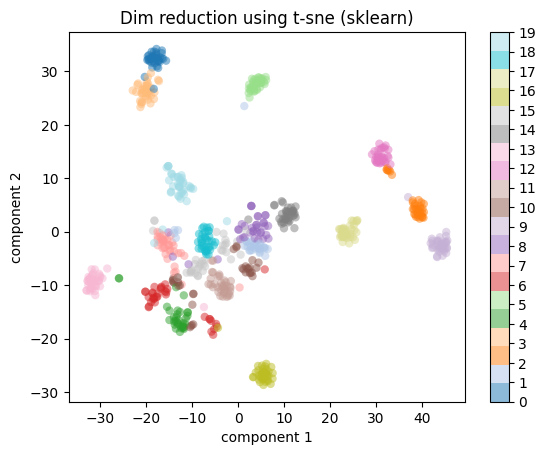

In [9]:
#We create a scatter plot of the t-sne dimensions reduced to 2D
plt.scatter(Dim_Reduced[:,0], Dim_Reduced[:,1],
            c=not_test_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 20))

#Using general labels for the axis as the component meaning is not preserved when reducing the dimensions
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dim reduction using t-sne (sklearn)')
plt.colorbar(ticks=range(0,20))

From the visual representation we can make judgements about the clustering of the datapoints and not their distance or density as a limitation of t-sne. Here we can see that while some clusters are largely unpolluted in terms of clarity other clusters such as 3 and 0 in the right of the graph have a degree of minor overlap, while other clusters such as 10 fail to have a unfied identity instead being split between various other areas. This shows us what classes of data are likely being confused in our previous classification tasks as while some classes are unpolluted such as 15 and 13 and as such have simple seperation other classes such as 10 are seperated into a number of clusters showing high degrees of similarity to other classes and as such showing a high likelyhood that the data is difficult to seperate for classification.

C:\Users\marsh\AppData\Local\Temp\ipykernel_17412\2405137282.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 20))


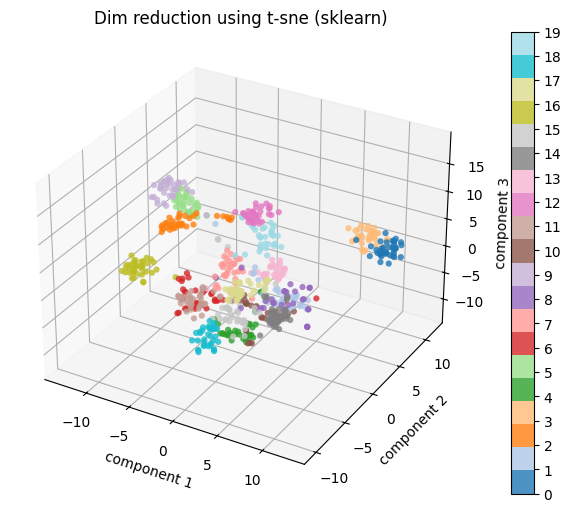

In [10]:
#Creating a 3D plot of the data with a projection figure
fig = plt.figure(figsize=(10,6))
plt.tight_layout()
ax = fig.add_subplot(projection='3d')

#Using the same methodology for the 2D plot with one added Z value
p = ax.scatter(Dim_Reduced_3[:,0], Dim_Reduced_3[:,1],Dim_Reduced_3[:,2],
            c=not_test_labels, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('tab20', 20))

#Labelling the plot and components
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.title('Dim reduction using t-sne (sklearn)')
fig.colorbar(p,ticks=range(0,20))

When analyzing the data in 3D we see very similar results as in two dimensions with identical classes overlapping into the same cluster. As such we do not change our findings from the two dimensional case as the only difference here is distance between clusters that is not readable from a t-sne plot.